In this tutorial you'll learn how to

* create groups
* create immutable fields
* display the entire content tree
* set up complex instruction sets
* set up leapfrog integration

For this notebook you need `astropy` and `matplotlib` in addition to the `simframe` requirements.

# Advanced Integration

Let's have a look at orbital integration.\
Consider a planet Earth orbiting the Sun. How does its orbit look like?

The equations of motion are determined by a set of two differential equations for the position $\vec{r}$ and velocity $\vec{v}$ of Earth and Sun..

$\frac{\mathrm{d}}{\mathrm{d}t} \vec{r} = \vec{v}$

$m\frac{\mathrm{d}}{\mathrm{d}t} \vec{v} = \vec{F}_\mathrm{G}$

The gravitational force $F_\mathrm{G}$ of a body of mass $M$ and position $\vec{R}$ acting on a body of mass $m$ at position $\vec{r}$ is given by

$\vec{F}_\mathrm{G} = -GmM\frac{\vec{r}-\vec{R}}{\left| \vec{r}-\vec{R} \right|^3}$

## Creating groups

First we need to add fields for postion, velocity, and mass for Earth and Sun.\
To have more structure we group the fields by Earth and Sun. This can be done with `addgroup(name)`.

In [1]:
from simframe import Frame

In [2]:
sim = Frame(description="Earth-Sun system")

In [3]:
sim.addgroup("Sun")
sim.addgroup("Earth")

The frame object has now two groups for Earth and Sun, that can be adressed just as fields.

In [4]:
sim

Frame (Earth-Sun system)
------------------------
    Earth        : Group
    Sun          : Group
  -----
    Integrator   : not specified
    Writer       : not specified

We will keep the problem general in three dimensions, but we will only use two of them for simplicity.\
Although spherical coordinates would be more suitable for the problem, we will use Carteesian coordinates here.

We'll use the `astropy.constants` and `astropy.units` modules for the constants and units we need here.

In [5]:
import astropy.constants as c
import astropy.units as u

In [6]:
AU   = (1.*u.au).si.value    # Astronomical unit [m]
day  = (1.*u.day).si.value   # Day [s]
G    = c.G.si.value          # Gravitational constant [m³/kg/s²]
year = (1.*u.year).si.value  # Year [s]

M_earth = c.M_earth.si.value # Mass of the Earth [kg]
M_sun   = c.M_sun.si.value   # Mass of the Sun [kg]

## Creating immutable fields

We can now fill the groups with the variables we need, starting with the masses.  
Again: the initial values must have the correct shape and data types.

In [7]:
sim.Earth.addfield("M", M_earth, description="Mass [kg]")

The groups and the fields within can be easily accessed with

In [8]:
sim.Earth

Group
-----
    M            : Field (Mass [kg])
  -----

In [9]:
sim.Earth.M

5.972167867791379e+24

The mass of the Earth shall be constant throughout the simulation. We therefore set a flag so we cannot accidentially change its value.

In [10]:
sim.Earth.M.constant = True

In [11]:
sim.Earth

Group
-----
    M            : Field (Mass [kg]), constant
  -----

Now we add the mass of the Sun, which we directly set to constant when adding the field.

In [12]:
sim.Sun.addfield("M", M_sun, constant=True, description="Mass [kg]")

In [13]:
sim.Sun

Group
-----
    M            : Field (Mass [kg]), constant
  -----

We can do all sorts of operations with those fields, such as calculating the mass ratio.

In [14]:
sim.Earth.M / sim.Sun.M

3.0034893488507934e-06

Now we need to add fields for position and velocity. We initialize them with zeros and think later about the initial conditions.\
The important thing is that the have the right shape upon initialization.

In [15]:
import numpy as np

In [16]:
sim.Earth.addfield("r", np.zeros(3), description="Position [m]")
sim.Earth.addfield("v", np.zeros(3), description="Velocity [m/s]")
sim.Sun.addfield("r", np.zeros(3), description="Position [m]")
sim.Sun.addfield("v", np.zeros(3), description="Velocity [m/s]")

In [17]:
sim.Earth

Group
-----
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    v            : Field (Velocity [m/s])
  -----

In [18]:
sim.Sun

Group
-----
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    v            : Field (Velocity [m/s])
  -----

**Setting the integration variable**

For our simulation we need an integration variable. In our case this is the time.

In [19]:
sim.addintegrationvariable("t", 0., description="Time [s]")

We'll set the step size to a constant value of one day.

In [20]:
dt = 1.*day

In [21]:
def f_dt(frame):
    return dt

In [22]:
sim.t.updater = f_dt

We want to integrate for two years and want to have a snapshot every ten days.

In [23]:
snapwidth = 10.*day
tmax = 2.*year

In [24]:
sim.t.snapshots = np.arange(snapwidth, tmax, snapwidth)

**Note:** If the initial value of the integration variable is smaller the first snapshot, `simframe` automatically writes an output with initial conditions, if a writer is set.

In [25]:
sim

Frame (Earth-Sun system)
------------------------
    Earth        : Group
    Sun          : Group
  -----
    t            : Field (Time [s]), Integration variable
  -----
    Integrator   : not specified
    Writer       : not specified

**Setting the writer**

As a writer we use the namespacewriter, which does not write the data into files, but stores them within a buffer in the writer.

In [26]:
from simframe import writers

In [27]:
sim.writer = writers.namespacewriter

We do not want to write dump files here.

In [28]:
sim.writer.dumping = False

In [29]:
sim.writer

Writer (Namespace writer)
-------------------------
    Data directory : data
    Dumping        : False
    Verbosity      : 1

**Adding differential equations**

As a next step we'll add differential equations to the quantities. The differential equations for the positions are simple. We simply return the velocities, which we can adress with the `frame` argument.

In [30]:
def dr_Earth(frame, x, Y):
    return frame.Earth.v

def dr_Sun(frame, x, Y):
    return frame.Sun.v

For the differential equations of the velocities we'll write a little helper function that computes the gravitational accelleration.

In [31]:
# Gravitational acceleration
def ag(M, r, R):
    direction = r-R
    distance = np.linalg.norm(direction)
    return -G * M * direction / distance**3

In [32]:
def dv_Earth(frame, x, Y):
    return ag(frame.Sun.M, frame.Earth.r, frame.Sun.r)

def dv_Sun(frame, x, Y):
    return ag(frame.Earth.M, frame.Sun.r, frame.Earth.r)

Now we need to add the differential equations to their fields.

In [33]:
sim.Earth.v.differentiator = dv_Earth
sim.Earth.r.differentiator = dr_Earth
sim.Sun.v.differentiator   = dv_Sun
sim.Sun.r.differentiator   = dr_Sun

## Displaying the table of contents

You can also display the complete tree structure of your frame.

In [34]:
sim.toc

Frame (Earth-Sun system)
    - Earth: Group
        - M: Field (Mass [kg]), constant
        - r: Field (Position [m])
        - v: Field (Velocity [m/s])
    - Sun: Group
        - M: Field (Mass [kg]), constant
        - r: Field (Position [m])
        - v: Field (Velocity [m/s])
    - t: Field (Time [s]), Integration variable


## Setting up complex integration instructions

Next we need to set up the integrator. We integrate all quantities with the explicit Euler 1st-order scheme as in the previous tutorial, but this time he have to integrate four fields. This can be easily achieved by adding four instructions.

In [35]:
from simframe import Integrator
from simframe.integration import Instruction
from simframe import schemes

In [36]:
sim.integrator = Integrator(sim.t, description="Euler 1st-order")

In [37]:
instructions_euler = [Instruction(schemes.expl_1_euler, sim.Earth.r),
                      Instruction(schemes.expl_1_euler, sim.Earth.v),
                      Instruction(schemes.expl_1_euler, sim.Sun.r  ),
                      Instruction(schemes.expl_1_euler, sim.Sun.v  ),
                     ]

In [38]:
sim.integrator.instructions = instructions_euler

**Initial conditions**

Before we can start the simulation, we have to think about initial conditions.

If we simply set the Sun at rest in the center of our simulation and only set the position and velocity of the Earth, then the center of mass would have a non-zero momentum and would slowly drift away from its initial position.

So what we do first: we set the Sun's positon to zero (i.e., don't do anything) and the Earth's position to a distance of 1 AU in positive x-direction. Then we'll offset their positions to center the system on the center of mass instead onto the Sun.

In [39]:
r_Earth_ini = np.array([AU, 0., 0.])
r_Sun_ini = np.zeros(3)
# Center of mass
COM_ini = (M_earth*r_Earth_ini + M_sun*r_Sun_ini) / (M_earth+M_sun)
# Offset both positions
r_Earth_ini -= COM_ini
r_Sun_ini -= COM_ini

We save them in a separate variable instead of assigning them directly for later use.

The inital orbital velocities of the Earth shall be in positive y-direction, the velocity of the Sun in negative y-direction.\
For calculating the value we use the reduced mass $mu$ of the system.

In [40]:
mu = M_earth*M_sun / (M_earth+M_sun)

In [41]:
v_Earth_ini = np.array([0., np.sqrt(G*M_sun/M_earth*mu/AU), 0.])
v_Sun_ini   = np.array([0., -np.sqrt(G*M_earth/M_sun*mu/AU), 0.])

Now we assign them to their fields.

In [42]:
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini

**Starting the simulation**

In [43]:
sim.run()

Saving frame 0
Saving frame 1
Saving frame 2
Saving frame 3
Saving frame 4
Saving frame 5
Saving frame 6
Saving frame 7
Saving frame 8
Saving frame 9
Saving frame 10
Saving frame 11
Saving frame 12
Saving frame 13
Saving frame 14
Saving frame 15
Saving frame 16
Saving frame 17
Saving frame 18
Saving frame 19
Saving frame 20
Saving frame 21
Saving frame 22
Saving frame 23
Saving frame 24
Saving frame 25
Saving frame 26
Saving frame 27
Saving frame 28
Saving frame 29
Saving frame 30
Saving frame 31
Saving frame 32
Saving frame 33
Saving frame 34
Saving frame 35
Saving frame 36
Saving frame 37
Saving frame 38
Saving frame 39
Saving frame 40
Saving frame 41
Saving frame 42
Saving frame 43
Saving frame 44
Saving frame 45
Saving frame 46
Saving frame 47
Saving frame 48
Saving frame 49
Saving frame 50
Saving frame 51
Saving frame 52
Saving frame 53
Saving frame 54
Saving frame 55
Saving frame 56
Saving frame 57
Saving frame 58
Saving frame 59
Saving frame 60
Saving frame 61
Saving frame 62
Sa

**Reading and plotting**

Reading data from the namespace writer works identical to the writer discussed earlier.

In [44]:
data_euler = sim.writer.read.all()

In [45]:
import matplotlib.pyplot as plt

def plot_orbits(data):
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect(1)
    ax.axis("off")
    fig.set_facecolor("#000000")
    imax = data.t.shape[0]
    for i in range(imax):
        alpha = np.maximum(i/imax-0.1, 0.5)
        ax.plot(data.Sun.r[i, 0], data.Sun.r[i, 1], "o", c="#FFFF00", markersize=4, alpha=alpha)
        ax.plot(data.Earth.r[i, 0], data.Earth.r[i, 1], "o", c="#0000FF", markersize=1, alpha=alpha)
    ax.plot(data.Sun.r[-1, 0], data.Sun.r[-1, 1], "o", c="#FFFF00", markersize=16)
    ax.plot(data.Earth.r[-1, 0], data.Earth.r[-1, 1], "o", c="#0000FF", markersize=4)
    ax.set_xlim(-1.5*AU, 1.5*AU)
    ax.set_ylim(-1.5*AU, 1.5*AU)
    fig.tight_layout()

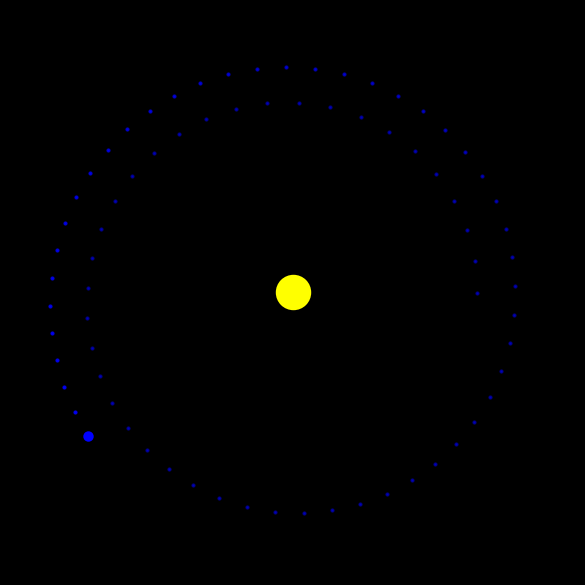

In [46]:
plot_orbits(data_euler)

## Leapfrog integration

As you can see, the Earth is not on a circular orbit. Its orbital distance is increasing and because of that the Earth could not achieve two full orbital cycles.

The problem is the simple integration scheme used here.\
Every integration scheme has numerical error. Some have larger ones than others. Euler's 1st order method is simply not suited for orbital integration.

But there is a way out: [Symplectic integration](https://en.wikipedia.org/wiki/Symplectic_integrator)\
Symplectic integrators conserve the energy of the system.

One of these methods is the Leapfrog method.\
Leapfrogging means the velocity and the position are not updated synchronous, but in between each other. They are leapfroggin each other.

In our case we first update the velocities by using half of the step size. Then we update the positions for a full time step. And finally, we update the velocities for another semi time step. We can do this by using the `fstep` keyword argument for the instructions, which is the fraction of the time for which this instruction is applied.

But there is one caveat: usually the fields that are integrated in an instructions set are only updated after all instructions have been executed, such that the second instruction still sees the original value of the first variable and not already the new value.

But for leapfrog integration, the instruction for the positions already need to know the new values of the velocities. And the second set of velocity instructions already need to know the new positions. We therefore have to add `update` instructions in between. 

We do not have to add update instructions after the second set of velocity operations, because at the end of an instruction set all fields contained in the instruction set will be updated.

The new leapfrog instruction set now looks like this.

In [47]:
instructions_leapfrog = [Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                         Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
                         Instruction(schemes.update,       sim.Sun.v             ),
                         Instruction(schemes.update,       sim.Earth.v           ),
                         Instruction(schemes.expl_1_euler, sim.Sun.r,   fstep=1.0),
                         Instruction(schemes.expl_1_euler, sim.Earth.r, fstep=1.0),
                         Instruction(schemes.update,       sim.Sun.r             ),
                         Instruction(schemes.update,       sim.Earth.r           ),
                         Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                         Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
                        ]

We can assign this new instruction set to our frame. To rerun the simulation we have to reset the initial conditions, that we've saved earlier.

In [48]:
sim.integrator.instructions = instructions_leapfrog
sim.integrator.description = "Leapfrog integrator"
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini
sim.t       = 0.

Additionally we have to reset the buffer of the namespace writer. Otherwise, we would simply add snapshots to the old dataset. Furthermore, we descrease the `verbosity` of the writer to prevent it from writing information on screen.

In [49]:
sim.writer.reset()
sim.writer.verbosity = 0

In [50]:
sim.run()

Execution time: 0:00:01


In [51]:
data_leapfrog = sim.writer.read.all()

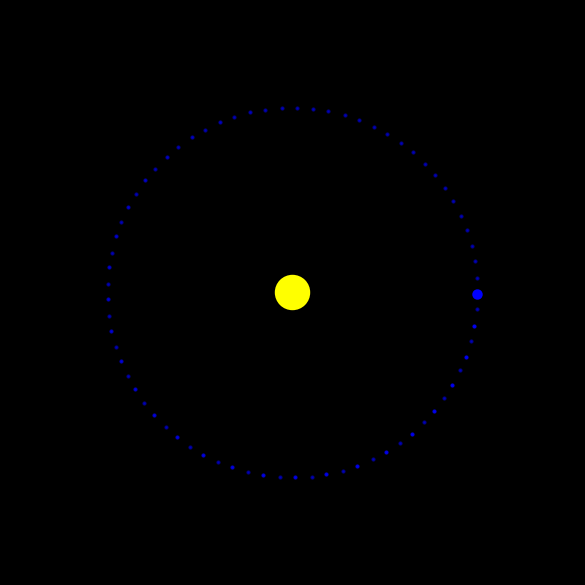

In [52]:
plot_orbits(data_leapfrog)